In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-mar-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2022/train.csv
/kaggle/input/tabular-playground-series-mar-2022/test.csv


In [2]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from sklearn.ensemble import GradientBoostingRegressor
import lightgbm
# from lightgbm import LGBMRegressor 

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [3]:
train = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2022/test.csv')

In [4]:
train

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60
...,...,...,...,...,...,...
848830,848830,1991-09-30 11:40:00,2,3,NB,54
848831,848831,1991-09-30 11:40:00,2,3,NE,28
848832,848832,1991-09-30 11:40:00,2,3,SB,68
848833,848833,1991-09-30 11:40:00,2,3,SW,17


In [5]:
test

,row_id,time,x,y,direction
0,848835,1991-09-30 12:00:00,0,0,EB
1,848836,1991-09-30 12:00:00,0,0,NB
2,848837,1991-09-30 12:00:00,0,0,SB
3,848838,1991-09-30 12:00:00,0,1,EB
4,848839,1991-09-30 12:00:00,0,1,NB
...,...,...,...,...,...
2335,851170,1991-09-30 23:40:00,2,3,NB
2336,851171,1991-09-30 23:40:00,2,3,NE
2337,851172,1991-09-30 23:40:00,2,3,SB
2338,851173,1991-09-30 23:40:00,2,3,SW


In [6]:
df_train = train.copy()
df_train = df_train.drop('row_id',1)
df_test = test.copy()
df_test = df_test.drop('row_id',1)

In [7]:
df_train['time'] = pd.to_datetime(df_train['time'], format='%Y-%m')
# df_train = df_train.set_index('time')
df_train

,time,x,y,direction,congestion
0,1991-04-01 00:00:00,0,0,EB,70
1,1991-04-01 00:00:00,0,0,NB,49
2,1991-04-01 00:00:00,0,0,SB,24
3,1991-04-01 00:00:00,0,1,EB,18
4,1991-04-01 00:00:00,0,1,NB,60
...,...,...,...,...,...
848830,1991-09-30 11:40:00,2,3,NB,54
848831,1991-09-30 11:40:00,2,3,NE,28
848832,1991-09-30 11:40:00,2,3,SB,68
848833,1991-09-30 11:40:00,2,3,SW,17


In [8]:
df_test['time'] = pd.to_datetime(df_test['time'], format='%Y-%m')
# df_test = df_test.set_index('time')
df_test

,time,x,y,direction
0,1991-09-30 12:00:00,0,0,EB
1,1991-09-30 12:00:00,0,0,NB
2,1991-09-30 12:00:00,0,0,SB
3,1991-09-30 12:00:00,0,1,EB
4,1991-09-30 12:00:00,0,1,NB
...,...,...,...,...
2335,1991-09-30 23:40:00,2,3,NB
2336,1991-09-30 23:40:00,2,3,NE
2337,1991-09-30 23:40:00,2,3,SB
2338,1991-09-30 23:40:00,2,3,SW


In [9]:
# df_train['time_step'] = np.arange(len(df_train.index))
# df_train

In [10]:
def details(df):
    sum_null_values = df.isnull().sum()
    percent_null_values = 100* (sum_null_values/len(df))
    data_type = df.dtypes
    unique_values = df.nunique()

    table = pd.concat([sum_null_values,percent_null_values,data_type,unique_values], axis=1)
    table_col = table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Missing Values', 2 : 'Data_Type', 3: 'Unique values'})
    return table_col

In [11]:
details(df_train)

,Missing Values,% of Total Missing Values,Data_Type,Unique values
time,0,0.0,datetime64[ns],13059
x,0,0.0,int64,3
y,0,0.0,int64,4
direction,0,0.0,object,8
congestion,0,0.0,int64,101


In [12]:
details(df_test)

,Missing Values,% of Total Missing Values,Data_Type,Unique values
time,0,0.0,datetime64[ns],36
x,0,0.0,int64,3
y,0,0.0,int64,4
direction,0,0.0,object,8


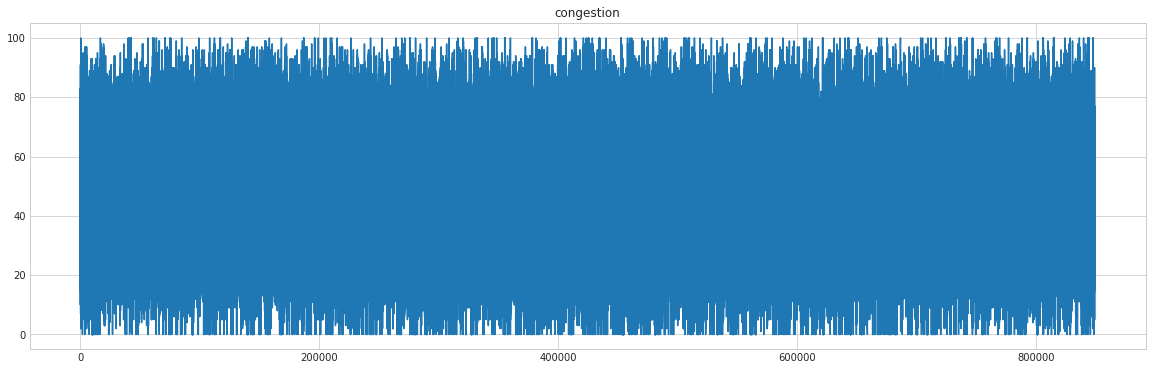

In [13]:
plt.figure(figsize=(20, 6))
plt.plot(df_train['congestion'])
plt.title('congestion')
plt.show()

<AxesSubplot:xlabel='congestion', ylabel='Count'>

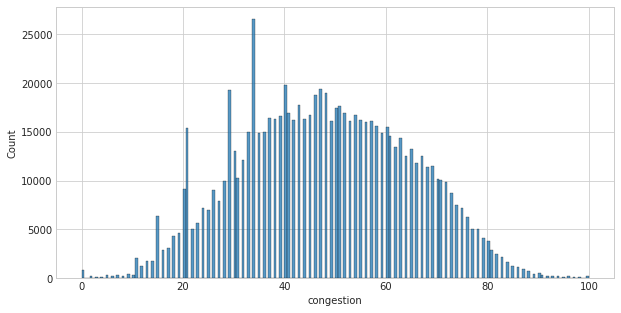

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(df_train['congestion'])

In [15]:
df_train.describe(percentiles=(.01,.05,.25,.5,.75,.9,.95,.99))

,x,y,congestion
count,848835.000000,848835.000000,848835.000000
mean,1.138462,1.630769,47.815305
std,0.801478,1.089379,16.799392
min,0.000000,0.000000,0.000000
1%,0.000000,0.000000,13.000000
5%,0.000000,0.000000,21.000000
25%,0.000000,1.000000,35.000000
50%,1.000000,2.000000,47.000000
75%,2.000000,3.000000,60.000000
90%,2.000000,3.000000,70.000000


In [16]:
df_train['direction'].value_counts()

EB    156708
NB    156708
SB    156708
WB    143649
NE     91413
SW     91413
NW     26118
SE     26118
Name: direction, dtype: int64

In [17]:
df_train['x'].value_counts()

2    339534
1    287298
0    222003
Name: x, dtype: int64

In [18]:
df_train['y'].value_counts()

2    235062
3    235062
1    208944
0    169767
Name: y, dtype: int64

In [19]:
df_train.groupby(['x','y','direction']).mean()

congestion
x y direction            
0 0 EB          47.396202
    NB          39.513286
    SB          49.864155
  1 EB          26.942492
    NB          68.888429
...                   ...
2 3 NB          58.609771
    NE          32.074585
    SB          70.617735
    SW          19.522322
    WB          44.233326

[65 rows x 1 columns]

In [20]:
df_train['weekday_no'] = df_train['time'].dt.dayofweek
df_train['week_day'] = df_train['time'].dt.day_name()
df_train['day_no'] = df_train['time'].dt.day
df_train['hr_day'] = df_train['time'].dt.hour
df_train['min_day'] = df_train['time'].dt.minute
df_train['month_name'] = df_train['time'].dt.month_name()
df_train['month'] = df_train['time'].dt.month
df_train['year_dayno'] = df_train['time'].dt.dayofyear
df_train

,time,x,y,direction,congestion,weekday_no,week_day,day_no,hr_day,min_day,month_name,month,year_dayno
0,1991-04-01 00:00:00,0,0,EB,70,0,Monday,1,0,0,April,4,91
1,1991-04-01 00:00:00,0,0,NB,49,0,Monday,1,0,0,April,4,91
2,1991-04-01 00:00:00,0,0,SB,24,0,Monday,1,0,0,April,4,91
3,1991-04-01 00:00:00,0,1,EB,18,0,Monday,1,0,0,April,4,91
4,1991-04-01 00:00:00,0,1,NB,60,0,Monday,1,0,0,April,4,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...
848830,1991-09-30 11:40:00,2,3,NB,54,0,Monday,30,11,40,September,9,273
848831,1991-09-30 11:40:00,2,3,NE,28,0,Monday,30,11,40,September,9,273
848832,1991-09-30 11:40:00,2,3,SB,68,0,Monday,30,11,40,September,9,273
848833,1991-09-30 11:40:00,2,3,SW,17,0,Monday,30,11,40,September,9,273


In [21]:
df_test['weekday_no'] = df_test['time'].dt.dayofweek
df_test['week_day'] = df_test['time'].dt.day_name()
df_test['day_no'] = df_test['time'].dt.day
df_test['hr_day'] = df_test['time'].dt.hour
df_test['min_day'] = df_test['time'].dt.minute
df_test['month_name'] = df_test['time'].dt.month_name()
df_test['month'] = df_test['time'].dt.month
df_test['year_dayno'] = df_test['time'].dt.dayofyear
df_test

,time,x,y,direction,weekday_no,week_day,day_no,hr_day,min_day,month_name,month,year_dayno
0,1991-09-30 12:00:00,0,0,EB,0,Monday,30,12,0,September,9,273
1,1991-09-30 12:00:00,0,0,NB,0,Monday,30,12,0,September,9,273
2,1991-09-30 12:00:00,0,0,SB,0,Monday,30,12,0,September,9,273
3,1991-09-30 12:00:00,0,1,EB,0,Monday,30,12,0,September,9,273
4,1991-09-30 12:00:00,0,1,NB,0,Monday,30,12,0,September,9,273
...,...,...,...,...,...,...,...,...,...,...,...,...
2335,1991-09-30 23:40:00,2,3,NB,0,Monday,30,23,40,September,9,273
2336,1991-09-30 23:40:00,2,3,NE,0,Monday,30,23,40,September,9,273
2337,1991-09-30 23:40:00,2,3,SB,0,Monday,30,23,40,September,9,273
2338,1991-09-30 23:40:00,2,3,SW,0,Monday,30,23,40,September,9,273


In [22]:
df_train['weekday_no'].value_counts()

0    124020
6    121680
4    121290
1    121225
2    121095
5    119925
3    119600
Name: weekday_no, dtype: int64

In [23]:
df_train['week_day'].value_counts()

Monday       124020
Sunday       121680
Friday       121290
Tuesday      121225
Wednesday    121095
Saturday     119925
Thursday     119600
Name: week_day, dtype: int64

In [24]:
df_train['day_no'].value_counts()

1     28080
10    28080
2     28080
25    28080
14    28080
13    28080
26    28080
11    28080
9     28080
22    28080
7     28080
6     28080
5     28080
28    28080
3     28080
27    27950
23    27950
16    27950
8     27950
20    27885
18    27820
15    27820
17    27755
4     27690
19    27560
21    27495
24    27495
29    27495
12    27300
30    25675
31    13845
Name: day_no, dtype: int64

In [25]:
df_train['hr_day'].value_counts()

0     35685
1     35685
2     35620
11    35555
22    35490
17    35490
16    35490
12    35490
6     35490
5     35490
4     35490
23    35490
9     35360
15    35360
18    35360
3     35360
8     35295
10    35295
13    35230
14    35230
7     35100
21    35100
20    34905
19    34775
Name: hr_day, dtype: int64

In [26]:
df_train['min_day'].value_counts()

40    283205
20    282945
0     282685
Name: min_day, dtype: int64

In [27]:
df_train['month_name'].value_counts()

July         144885
May          144560
August       143650
June         140140
April        139880
September    135720
Name: month_name, dtype: int64

In [28]:
df_train['month'].value_counts()

7    144885
5    144560
8    143650
6    140140
4    139880
9    135720
Name: month, dtype: int64

In [29]:
df_train['year_dayno'].value_counts()

91     4680
196    4680
198    4680
200    4680
202    4680
       ... 
262    4160
264    4095
241    4095
255    3900
273    2340
Name: year_dayno, Length: 183, dtype: int64

In [30]:
df_train

,time,x,y,direction,congestion,weekday_no,week_day,day_no,hr_day,min_day,month_name,month,year_dayno
0,1991-04-01 00:00:00,0,0,EB,70,0,Monday,1,0,0,April,4,91
1,1991-04-01 00:00:00,0,0,NB,49,0,Monday,1,0,0,April,4,91
2,1991-04-01 00:00:00,0,0,SB,24,0,Monday,1,0,0,April,4,91
3,1991-04-01 00:00:00,0,1,EB,18,0,Monday,1,0,0,April,4,91
4,1991-04-01 00:00:00,0,1,NB,60,0,Monday,1,0,0,April,4,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...
848830,1991-09-30 11:40:00,2,3,NB,54,0,Monday,30,11,40,September,9,273
848831,1991-09-30 11:40:00,2,3,NE,28,0,Monday,30,11,40,September,9,273
848832,1991-09-30 11:40:00,2,3,SB,68,0,Monday,30,11,40,September,9,273
848833,1991-09-30 11:40:00,2,3,SW,17,0,Monday,30,11,40,September,9,273


In [31]:
X = df_train.drop(['time','congestion','weekday_no','month'],1)
y = df_train['congestion']
X_test = df_test.drop(['time','weekday_no','month'],1)

In [32]:
ohe = OneHotEncoder(sparse=False)
ohe_df1 = pd.DataFrame(ohe.fit_transform(X[['direction','week_day','month_name']]),columns=ohe.get_feature_names())
ohe_df2 = pd.DataFrame(ohe.transform(X_test[['direction','week_day','month_name']]),columns=ohe.get_feature_names())

In [33]:
X.drop(['direction','week_day','month_name'],1,inplace=True)
X = pd.concat([X, ohe_df1],1)
X_test.drop(['direction','week_day','month_name'],1,inplace=True)
X_test = pd.concat([X_test, ohe_df2],1)

In [34]:
X

,x,y,day_no,hr_day,min_day,year_dayno,x0_EB,x0_NB,x0_NE,x0_NW,...,x1_Sunday,x1_Thursday,x1_Tuesday,x1_Wednesday,x2_April,x2_August,x2_July,x2_June,x2_May,x2_September
0,0,0,1,0,0,91,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,0,0,91,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,0,1,0,0,91,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,1,1,0,0,91,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,1,1,0,0,91,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848830,2,3,30,11,40,273,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
848831,2,3,30,11,40,273,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
848832,2,3,30,11,40,273,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
848833,2,3,30,11,40,273,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [35]:
X.columns

Index(['x', 'y', 'day_no', 'hr_day', 'min_day', 'year_dayno', 'x0_EB', 'x0_NB',
       'x0_NE', 'x0_NW', 'x0_SB', 'x0_SE', 'x0_SW', 'x0_WB', 'x1_Friday',
       'x1_Monday', 'x1_Saturday', 'x1_Sunday', 'x1_Thursday', 'x1_Tuesday',
       'x1_Wednesday', 'x2_April', 'x2_August', 'x2_July', 'x2_June', 'x2_May',
       'x2_September'],
      dtype='object')

In [36]:
X_test

,x,y,day_no,hr_day,min_day,year_dayno,x0_EB,x0_NB,x0_NE,x0_NW,...,x1_Sunday,x1_Thursday,x1_Tuesday,x1_Wednesday,x2_April,x2_August,x2_July,x2_June,x2_May,x2_September
0,0,0,30,12,0,273,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,30,12,0,273,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,30,12,0,273,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,1,30,12,0,273,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,1,30,12,0,273,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,2,3,30,23,40,273,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2336,2,3,30,23,40,273,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2337,2,3,30,23,40,273,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2338,2,3,30,23,40,273,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [37]:
scaler = StandardScaler()
X[['x', 'y', 'day_no', 'hr_day', 'min_day', 'year_dayno']] = scaler.fit_transform(X[['x', 'y', 'day_no', 'hr_day', 'min_day', 'year_dayno']])
X_test[['x', 'y', 'day_no', 'hr_day', 'min_day', 'year_dayno']] = scaler.transform(X_test[['x', 'y', 'day_no', 'hr_day', 'min_day', 'year_dayno']])

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=23)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((594184, 27), (254651, 27), (594184,), (254651,))

In [39]:
model = list()
resample  = list()
r2score_train = list()
r2score_valid = list()
error_train = list()
error_valid = list()

In [40]:
# neg_mean_absolute_error

In [41]:
model_LR = LinearRegression()
model_DT = DecisionTreeRegressor(random_state = 23)
model_RF = RandomForestRegressor(random_state=23) #oob_score = True, bootstrap = True,
model_LGBM = lightgbm.LGBMRegressor(objective = 'regression', random_state=23)
# model_XGB = XGBRegressor(use_rmm=True, random_state=23)
print(model_LR)
print(model_DT)
print(model_RF)
print(model_LGBM)
# print(model_XGB)

LinearRegression()
DecisionTreeRegressor(random_state=23)
RandomForestRegressor(random_state=23)
LGBMRegressor(objective='regression', random_state=23)


In [42]:
params_DT = {
    'max_depth': [5, 10, 20, 50, 100, 200],
    'min_samples_leaf': [5, 10, 20, 50, 100, 200],
    'min_samples_split' : [5, 10, 20, 50, 100, 200]
} 
# 'min_samples_split': 100, 'min_samples_leaf': 10, 'max_depth': 20
# 'min_samples_split': 50, 'min_samples_leaf': 5, 'max_depth': 200


params_RF = {    
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, 50, 100, 200],
    'min_samples_leaf': [5, 10, 20, 50, 100, 200],
    'min_samples_split' : [5, 10, 20, 50, 100, 200],
    'oob_score': ['True'],
    'bootstrap': ['True'],
    'max_samples': [0.4,0.8]    
}

# params_GBM = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 20, 50, 100, 200],
#     'min_samples_leaf': [5, 10, 20, 50, 100, 200],
#     'min_samples_split' : [5, 10, 20, 50, 100, 200],
#     'subsample': [0.3, 0.7],
#     'learning_rate': [0.01, 0.1]    
# }

#RF
#'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 200
# 'n_estimators': 50, 'min_samples_split': 100, 'min_samples_leaf': 5, 'max_depth': 100
# 'oob_score': 'True', 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 50, 'max_samples': 0.8, 'max_depth': 100, 'bootstrap': 'True'

# params_XGB = {
#     'n_estimators': [50], #[5, 10, 20, 50, 100, 200, 500],
#     'sampling_method': ['gradient_based'],
#     'tree_method': ['gpu_hist'],
#     'max_depth': [2, 5, 10, 15, 20, 30],  
#     'min_child_weight': [1, 2, 5],
# #     'early_stopping_rounds': [5],
# #     'subsample': [0.5,1],
#     'learning_rate': [0.01]
# #     alpha
# }

params_LGBM = {
    'n_estimators': [50, 100, 200],
    'boosting_type': ['gbdt','dart'],
    'max_depth': [5, 10, 20, 50, 100, 200], 
    'min_child_samples': [5, 10, 20, 50, 100, 200],
#     'early_stopping_round': [5],
    'subsample': [0.2,0.5,0.7,1.0],        
    'learning_rate': [0.01, 0.1]
#     'lambda'
}
# 'subsample': 0.2, 'n_estimators': 200, 'min_child_samples': 50, 'max_depth': 20, 'learning_rate': 0.1, 'early_stopping': 5, 'boosting_type': 'dart'

In [43]:
model_LGBM.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [44]:
def model_fit_evaluation1(model_model, X_train, y_train, X_valid, y_valid, algo=None, sampling=None):
    
    lr = model_model.fit(X_train, y_train)

    # Train set prediction
    y_train_pred = lr.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    
    #Mean Absolute error - train
    mae_train = mean_absolute_error(y_train, y_train_pred)

    # Test set prediction    
    y_val_pred = lr.predict(X_valid)
    r2_valid = r2_score(y_valid, y_val_pred)
    
    #Mean Absolute error - val
    mae_val = mean_absolute_error(y_val, y_val_pred)
    
    print('R-Squared_train')
    print('='*60)
    print(r2_train,"\n")
    print('R-Squared_valid')
    print('='*60)
    print(r2_valid,"\n")    
    print('Mean absolute error - train')
    print('='*60)
    print(mae_train,"\n")
    print('Mean absolute error - val')
    print('='*60)
    print(mae_val,"\n")    
    
    model.append(algo)
    resample.append(sampling)
    r2score_train.append(r2_train)
    r2score_valid.append(r2_valid)
    error_train.append(mae_train) 
    error_valid.append(mae_val) 

In [45]:
def model_fit_evaluation2(model_model, params, X_train, y_train, X_valid, y_valid, algo=None, sampling=None):
    
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=23)
    rc = RandomizedSearchCV(model_model, params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, random_state=23)
    rcv = rc.fit(X_train, y_train)
    # rcv = rc.best_estimator_
    
    print('\n')
    print('get params: ', rcv.get_params())
    print('best estimator : ', rcv.best_estimator_)
    print('best parameters: ', rcv.best_params_)
    print('best score: ', rcv.best_score_)
    print('\n')

        # Train set prediction
    y_train_pred = (rcv.best_estimator_).predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    
    #Mean Absolute error - train
    mae_train = mean_absolute_error(y_train, y_train_pred)

    # Test set prediction    
    y_val_pred = (rcv.best_estimator_).predict(X_valid)
    r2_valid = r2_score(y_valid, y_val_pred)
    
    #Mean Absolute error - val
    mae_val = mean_absolute_error(y_val, y_val_pred)
    
    print('R-Squared_train')
    print('='*60)
    print(r2_train,"\n")
    print('R-Squared_valid')
    print('='*60)
    print(r2_valid,"\n")    
    print('Mean absolute error - train')
    print('='*60)
    print(mae_train,"\n")
    print('Mean absolute error - val')
    print('='*60)
    print(mae_val,"\n")  
    
    model.append(algo)
    resample.append(sampling)
    r2score_train.append(r2_train)
    r2score_valid.append(r2_valid)
    error_train.append(mae_train) 
    error_valid.append(mae_val) 

In [46]:
model_fit_evaluation1(model_LR, X_train, y_train, X_val, y_val, 'Linear Regression', 'without HPT')

R-Squared_train
0.197414783616227 

R-Squared_valid
0.19613037799726474 

Mean absolute error - train
12.125062419906522 

Mean absolute error - val
12.122408579997948 



In [47]:
%%time
model_fit_evaluation1(model_DT, X_train, y_train, X_val, y_val, 'Decision Tree', 'without HPT')

R-Squared_train
1.0 

R-Squared_valid
0.5321460442750183 

Mean absolute error - train
0.0 

Mean absolute error - val
7.739804673847737 

CPU times: user 7.29 s, sys: 91.8 ms, total: 7.38 s
Wall time: 7.38 s


In [48]:
model_fit_evaluation2(model_DT, params_DT, X_train, y_train, X_val, y_val, 'Decision Tree', 'with HPT')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished




get params:  {'cv': 5, 'error_score': nan, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'mse', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__presort': 'deprecated', 'estimator__random_state': 23, 'estimator__splitter': 'best', 'estimator': DecisionTreeRegressor(random_state=23), 'iid': 'deprecated', 'n_iter': 10, 'n_jobs': -1, 'param_distributions': {'max_depth': [5, 10, 20, 50, 100, 200], 'min_samples_leaf': [5, 10, 20, 50, 100, 200], 'min_samples_split': [5, 10, 20, 50, 100, 200]}, 'pre_dispatch': '2*n_jobs', 'random_state': 23, 'refit': True, 'return_train_score': False, 'scoring': 'neg_mean_absolute_error', 'verbose': 1}
best estimator :  DecisionTreeRegressor(max_depth=200, min_samples_leaf=5, min_samples_split=50,
   

In [49]:
%%time
model_fit_evaluation1(model_RF, X_train, y_train, X_val, y_val, 'Random Forest', 'without HPT')

R-Squared_train
0.9647147001723049 

R-Squared_valid
0.7478606111934796 

Mean absolute error - train
2.1723166897795965 

Mean absolute error - val
5.850982953139788 

CPU times: user 8min 11s, sys: 3.95 s, total: 8min 15s
Wall time: 8min 15s


In [50]:
model_fit_evaluation2(model_RF, params_RF, X_train, y_train, X_val, y_val, 'Random Forest', 'with HPT')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 61.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 74.6min finished




get params:  {'cv': 5, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'mse', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 23, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(random_state=23), 'iid': 'deprecated', 'n_iter': 10, 'n_jobs': -1, 'param_distributions': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20, 50, 100, 200], 'min_samples_leaf': [5, 10, 20, 50, 100, 200], 'min_samples_split': [5, 10, 20, 50, 100, 200], 'oob_score': ['True'], 'bootstrap': ['True'], 'max_samples': [0.4, 0.

In [51]:
%%time
model_fit_evaluation1(model_LGBM, X_train, y_train, X_val, y_val, 'LGBM', 'without HPT')

R-Squared_train
0.6699232599748344 

R-Squared_valid
0.670141879955091 

Mean absolute error - train
7.028201279626776 

Mean absolute error - val
7.0162403161583855 

CPU times: user 15.5 s, sys: 233 ms, total: 15.7 s
Wall time: 4.39 s


In [52]:
model_fit_evaluation2(model_LGBM, params_LGBM, X_train, y_train, X_val, y_val, 'LGBM', 'with HPT')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.3min finished




get params:  {'cv': 5, 'error_score': nan, 'estimator__boosting_type': 'gbdt', 'estimator__class_weight': None, 'estimator__colsample_bytree': 1.0, 'estimator__importance_type': 'split', 'estimator__learning_rate': 0.1, 'estimator__max_depth': -1, 'estimator__min_child_samples': 20, 'estimator__min_child_weight': 0.001, 'estimator__min_split_gain': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': -1, 'estimator__num_leaves': 31, 'estimator__objective': 'regression', 'estimator__random_state': 23, 'estimator__reg_alpha': 0.0, 'estimator__reg_lambda': 0.0, 'estimator__silent': 'warn', 'estimator__subsample': 1.0, 'estimator__subsample_for_bin': 200000, 'estimator__subsample_freq': 0, 'estimator': LGBMRegressor(objective='regression', random_state=23), 'iid': 'deprecated', 'n_iter': 10, 'n_jobs': -1, 'param_distributions': {'n_estimators': [50, 100, 200], 'boosting_type': ['gbdt', 'dart'], 'max_depth': [5, 10, 20, 50, 100, 200], 'min_child_samples': [5, 10, 20, 50, 100, 200], '

In [53]:
# %%time
# model_fit_evaluation1(model_XGB, X_train, y_train, X_val, y_val, 'XGB Regressor', 'without HPT')

In [54]:
# model_fit_evaluation2(model_XGB, params_XGB, X_train, y_train, X_val, y_val, 'XGB Regressor', 'with HPT')

In [55]:
# DT: 0, 7, 5.5, 6.3
# RF: 2.1, 5.8, 6.1, 6.2


In [56]:
eval_df = pd.DataFrame({'model': model, 'resample': resample, 'r2score_train': r2score_train, 'r2score_valid': r2score_valid, 'error_train': error_train, 'error_valid': error_valid})
eval_df

,model,resample,r2score_train,r2score_valid,error_train,error_valid
0,Linear Regression,without HPT,0.197415,0.196130,12.125062,12.122409
1,Decision Tree,without HPT,1.000000,0.532146,0.000000,7.739805
2,Decision Tree,with HPT,0.776478,0.712143,5.578317,6.331335
3,Random Forest,without HPT,0.964715,0.747861,2.172317,5.850983
4,Random Forest,with HPT,0.732195,0.720412,6.113309,6.246504
5,LGBM,without HPT,0.669923,0.670142,7.028201,7.016240
6,LGBM,with HPT,0.688298,0.687086,6.776926,6.780314


In [57]:
X.shape, X_test.shape

((848835, 27), (2340, 27))

In [58]:
rc1 = RandomizedSearchCV(model_RF, params_RF, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, random_state=23)
rcv1 = rc1.fit(X, y)
# rcv = rc.best_estimator_

print('\n')
print('get params: ', rcv1.get_params())
print('best estimator : ', rcv1.best_estimator_)
print('best parameters: ', rcv1.best_params_)
print('best score: ', rcv1.best_score_)
print('\n')

    # Train set prediction
y_train_pred1 = (rcv1.best_estimator_).predict(X)
r2_train1 = r2_score(y, y_train_pred1)

#Mean Absolute error - train
mae_train1 = mean_absolute_error(y, y_train_pred1)

# Test set prediction    
y_test_pred1 = (rcv1.best_estimator_).predict(X_test)
# r2_test = r2_score(y, y_test_pred)

#Mean Absolute error - test
# mae_val = mean_absolute_error(y, y_test_pred)

print('R-Squared_train')
print('='*60)
print(r2_train1,"\n")   
print('Mean absolute error - train')
print('='*60)
print(mae_train1,"\n") 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 74.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 89.1min finished




get params:  {'cv': 5, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'mse', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 23, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(random_state=23), 'iid': 'deprecated', 'n_iter': 10, 'n_jobs': -1, 'param_distributions': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20, 50, 100, 200], 'min_samples_leaf': [5, 10, 20, 50, 100, 200], 'min_samples_split': [5, 10, 20, 50, 100, 200], 'oob_score': ['True'], 'bootstrap': ['True'], 'max_samples': [0.4, 0.

In [59]:
# rc2 = RandomizedSearchCV(model_LGBM, params_LGBM, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, random_state=23)
# rcv2 = rc2.fit(X, y)
# # rcv = rc.best_estimator_

# print('\n')
# print('get params: ', rcv2.get_params())
# print('best estimator : ', rcv2.best_estimator_)
# print('best parameters: ', rcv2.best_params_)
# print('best score: ', rcv2.best_score_)
# print('\n')

#     # Train set prediction
# y_train_pred2 = (rcv2.best_estimator_).predict(X)
# r2_train2 = r2_score(y, y_train_pred2)

# #Mean Absolute error - train
# mae_train2 = mean_absolute_error(y, y_train_pred2)

# # Test set prediction    
# y_test_pred2 = (rcv2.best_estimator_).predict(X_test)
# # r2_test = r2_score(y, y_test_pred)

# #Mean Absolute error - test
# # mae_val = mean_absolute_error(y, y_test_pred)

# print('R-Squared_train')
# print('='*60)
# print(r2_train2,"\n")   
# print('Mean absolute error - train')
# print('='*60)
# print(mae_train2,"\n") 

In [60]:
predictions = y_test_pred1
submission = pd.DataFrame({ 'row_id' : test['row_id'], 'congestion': predictions })
submission.shape

(2340, 2)

In [61]:
submission

,row_id,congestion
0,848835,49.840044
1,848836,34.816404
2,848837,47.110638
3,848838,27.751329
4,848839,72.004509
...,...,...
2335,851170,67.393391
2336,851171,34.257537
2337,851172,70.433030
2338,851173,17.473209


In [62]:
submission.to_csv('submission.csv', index = False)
submission

,row_id,congestion
0,848835,49.840044
1,848836,34.816404
2,848837,47.110638
3,848838,27.751329
4,848839,72.004509
...,...,...
2335,851170,67.393391
2336,851171,34.257537
2337,851172,70.433030
2338,851173,17.473209
